<a href="https://colab.research.google.com/github/davism02/Project-4-Predicting-Hospial-Readmission-for-Diabetes/blob/main/diabetes_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
url ='https://raw.githubusercontent.com/davism02/Project-4-Predicting-Hospial-Readmission-for-Diabetes/main/Resources/diabetic_data.csv'

In [2]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [4]:
df = pd.read_csv(url)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
# Include only the interested features

df = df.iloc[:, [2,3,4,5,9,22,41,48,49]]

df.head()

,race,gender,age,weight,time_in_hospital,max_glu_serum,insulin,diabetesMed,readmitted
0,Caucasian,Female,[0-10),?,1,None,No,No,NO
1,Caucasian,Female,[10-20),?,3,None,Up,Yes,>30
2,AfricanAmerican,Female,[20-30),?,2,None,No,Yes,NO
3,Caucasian,Male,[30-40),?,2,None,Up,Yes,NO
4,Caucasian,Male,[40-50),?,1,None,Steady,Yes,NO


In [6]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())

race 2273
gender 0
age 0
weight 98569
max_glu_serum 0
insulin 0
diabetesMed 0
readmitted 0


In [7]:
# Drop rows with invalid values (?)
df = df[(df.race != "?") & (df.gender != "?") & (df.age != "?") & (df.weight != "?")]
df

,race,gender,age,weight,time_in_hospital,max_glu_serum,insulin,diabetesMed,readmitted
1102,Caucasian,Male,[50-60),[75-100),2,None,Steady,Yes,>30
1132,Caucasian,Female,[60-70),[0-25),5,None,Steady,Yes,>30
1136,Caucasian,Female,[40-50),[75-100),3,None,Steady,Yes,NO
1190,Caucasian,Female,[70-80),[75-100),11,None,Steady,Yes,NO
1204,Caucasian,Female,[80-90),[50-75),9,None,Steady,Yes,>30
...,...,...,...,...,...,...,...,...,...
101456,AfricanAmerican,Male,[60-70),[75-100),2,None,No,No,>30
101516,Caucasian,Male,[60-70),[100-125),4,None,No,Yes,>30
101640,Caucasian,Female,[70-80),[50-75),8,None,Steady,Yes,NO
101667,Caucasian,Male,[70-80),[75-100),4,None,No,Yes,<30


In [8]:
# Convert readmitted column to binary field
df = df.replace({'readmitted': {"NO": 0, ">30": 0, "<30": 1}})
df

,race,gender,age,weight,time_in_hospital,max_glu_serum,insulin,diabetesMed,readmitted
1102,Caucasian,Male,[50-60),[75-100),2,None,Steady,Yes,0
1132,Caucasian,Female,[60-70),[0-25),5,None,Steady,Yes,0
1136,Caucasian,Female,[40-50),[75-100),3,None,Steady,Yes,0
1190,Caucasian,Female,[70-80),[75-100),11,None,Steady,Yes,0
1204,Caucasian,Female,[80-90),[50-75),9,None,Steady,Yes,0
...,...,...,...,...,...,...,...,...,...
101456,AfricanAmerican,Male,[60-70),[75-100),2,None,No,No,0
101516,Caucasian,Male,[60-70),[100-125),4,None,No,Yes,0
101640,Caucasian,Female,[70-80),[50-75),8,None,Steady,Yes,0
101667,Caucasian,Male,[70-80),[75-100),4,None,No,Yes,1


In [9]:
#Checking data types of each variable
df.dtypes

race                object
gender              object
age                 object
weight              object
time_in_hospital     int64
max_glu_serum       object
insulin             object
diabetesMed         object
readmitted           int64
dtype: object

In [10]:
# Determine the number of unique values in each column.
df.nunique()

race                 4
gender               2
age                 10
weight               9
time_in_hospital    14
max_glu_serum        1
insulin              4
diabetesMed          2
readmitted           2
dtype: int64

In [11]:
# Drop column since there is only 1 unique value
df = df.drop(['max_glu_serum'], axis = 1)

In [13]:
# Convert categorical data to numeric with label encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['race'] = le.fit_transform(df['race'])
df['gender'] = le.fit_transform(df['gender'])
df['age'] = le.fit_transform(df['age'])
df['weight'] = le.fit_transform(df['weight'])
df['insulin'] = le.fit_transform(df['insulin'])
df['diabetesMed'] = le.fit_transform(df['diabetesMed'])
df

,race,gender,age,weight,time_in_hospital,insulin,diabetesMed,readmitted
1102,2,1,5,8,2,2,1,0
1132,2,0,6,1,5,2,1,0
1136,2,0,4,8,3,2,1,0
1190,2,0,7,8,11,2,1,0
1204,2,0,8,7,9,2,1,0
...,...,...,...,...,...,...,...,...
101456,0,1,6,8,2,1,0,0
101516,2,1,6,2,4,1,1,0
101640,2,0,7,7,8,2,1,0
101667,2,1,7,8,4,1,1,1


In [14]:
df.shape

(3059, 8)

In [15]:
# Check null values
df.isnull().sum()

race                0
gender              0
age                 0
weight              0
time_in_hospital    0
insulin             0
diabetesMed         0
readmitted          0
dtype: int64

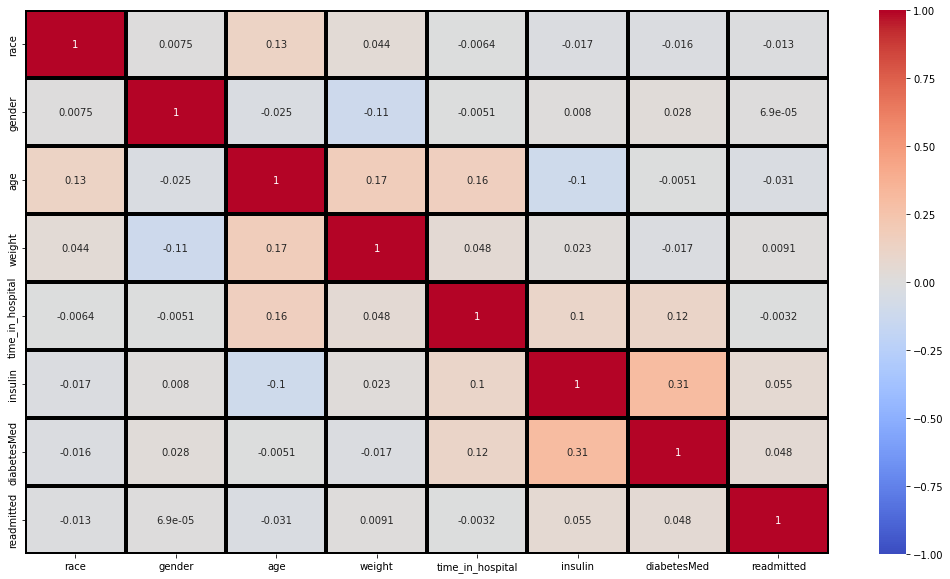

In [20]:
# Explore correlation between features via a heatmap
fix, ax = plt.subplots(figsize = (18, 10))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center =0, cmap = 'coolwarm', linewidths=3, linecolor='black',)

In [12]:
df.to_csv("final_data.csv")

In [16]:
# Split our preprocessed data into our features and target arrays
y = df['readmitted']
X = df.drop(columns = ["readmitted"], axis=1)

In [17]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state= 42)

In [18]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
# Number of features in datast
len(X.columns)

7

In [ ]:
# Our heatmap shows strong correlation between a few columns. 
# Not having insulin is highly correlated with not taking diabetes medicines. Having steady insulin is also correlated with taking diabetes medicine. 

In [ ]:
# Compile, Train and Evalutate the Model

In [21]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
import pickle

lg = LogisticRegression(max_iter=1000)

In [22]:
lg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [23]:
y_pred = lg.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [24]:
print(f'Training Score: {lg.score(X_train, y_train)}')
print(f'Testing Score: {lg.score(X_test, y_test)}')

Training Score: 0.8836094158674804
Testing Score: 0.8967320261437909


In [25]:
from sklearn.metrics import confusion_matrix , classification_report

target_names = ['not readmitted', 'readmitted']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

not readmitted       0.90      1.00      0.95       686
    readmitted       0.00      0.00      0.00        79

      accuracy                           0.90       765
     macro avg       0.45      0.50      0.47       765
  weighted avg       0.80      0.90      0.85       765



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# The classification report shows that recall is high, meaning that the classifier is missing some 'readmits' because it is being too careful. 
# The F1 score, a balance of precision and recall is higher for readmitted patients than for patients who are not readmitted. 


In [ ]:
# Random Forest


In [26]:
## Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

number_input_features = len( X_train_scaled[0])
hidden_nodes_layer1=7
hidden_nodes_layer2=14
hidden_nodes_layer3=21
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='relu'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dense_1 (Dense)             (None, 14)                112       
                                                                 
 dense_2 (Dense)             (None, 21)                315       
                                                                 
 dense_3 (Dense)             (None, 1)                 22        
                                                                 
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compile the model
nn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [28]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,validation_split=0.15, epochs=100)

Epoch 1/100
61/61 [==============================] - 1s 5ms/step - loss: 0.6362 - accuracy: 0.7147 - val_loss: 0.4994 - val_accuracy: 0.8986
Epoch 2/100
61/61 [==============================] - 0s 2ms/step - loss: 0.4381 - accuracy: 0.8810 - val_loss: 0.3637 - val_accuracy: 0.8986
Epoch 3/100
61/61 [==============================] - 0s 3ms/step - loss: 0.3882 - accuracy: 0.8810 - val_loss: 0.3430 - val_accuracy: 0.8986
Epoch 4/100
61/61 [==============================] - 0s 2ms/step - loss: 0.3762 - accuracy: 0.8810 - val_loss: 0.3346 - val_accuracy: 0.8986
Epoch 5/100
61/61 [==============================] - 0s 2ms/step - loss: 0.3702 - accuracy: 0.8810 - val_loss: 0.3306 - val_accuracy: 0.8986
Epoch 6/100
61/61 [==============================] - 0s 2ms/step - loss: 0.3679 - accuracy: 0.8810 - val_loss: 0.3276 - val_accuracy: 0.8986
Epoch 7/100
61/61 [==============================] - 0s 2ms/step - loss: 0.3657 - accuracy: 0.8810 - val_loss: 0.3292 - val_accuracy: 0.8986
Epoch 8/100
6

In [29]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

24/24 - 0s - loss: 0.3380 - accuracy: 0.8967 - 42ms/epoch - 2ms/step
Loss: 0.3380376696586609, Accuracy: 0.8967320322990417


In [ ]:
# Export our model to HDF5 file
from google.colab import files

nn.save('/content/Model_1.h5')
files.download('/content/Model_1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>